## DeepFalcon
* Specific Task 2 (if you are interested in “Diffusion Models for Fast Detector Simulation” project):
Use a Diffusion Network model to represent the events in task 1. Please show a side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice that estimates the difference between the two.


## Genie
* Specific Task 3 (if you are interested in “Learning the Latent Structure with Diffusion Models” project):
Use a Diffusion Network model to represent the events in task 1. Please show a side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice that estimates the difference between the two.


In [1]:
import torch
import numpy as np 
import h5py
import os
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import torchvision
import random
import cv2
from functools import  partial
import math
import matplotlib.colors as colors
from typing import Optional

/tmp/ipykernel_107544/798186862.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

## DATA PREPROCESSING

In [3]:
data_path = 'quark-gluon_data-set_n139306.hdf5'


In [4]:
class Quark_Gluon_Dataset(torch.utils.data.Dataset):
    def __init__(self,root_path,num_samples= 10000,transform=None):
        self.root_path = root_path
        self.transform = transform
        self.num_samples = num_samples
        self.f = h5py.File(self.root_path,'r')
        self.data_length = len(self.f['y'][:num_samples]) # subset of samples due to limited computation

        self.X_jets = self.f['X_jets'][:num_samples]
        self.y = self.f['y'][:num_samples]
        # self.X_jets = (self.X_jets - self.X_jets.min())/(self.X_jets.max()-self.X_jets.min()) #normalization
        # print(self.X_jets.shape)
        if self.transform:
            self.X_jets = self.transform(torch.as_tensor(np.array(self.X_jets)).permute(0,3,1,2)) # BxHxWxC ----> BxCxHxW
        
    def __getitem__(self,idx):
        X_jets = self.X_jets[idx]           # images
        # mass = f['m0'][:1000][idx]        # mass
        # momentum = f['pt'][:1000][idx]    # transverse momentum
        y = self.y[idx]                     # labels

        return torch.as_tensor(np.array(X_jets)),torch.as_tensor(np.array(y))

    def __len__(self):
        return self.data_length

In [5]:
def standardization(data):
    mean_tracks = torch.mean(data[:,0,:,:])
    std_tracks = torch.std(data[:,0,:,:])
    track_standardized = (data[:,0,:,:] - mean_tracks)/std_tracks

    mean_ecal = torch.mean(data[:,1,:,:])
    std_ecal = torch.std(data[:,1,:,:])
    ecal_standardized = (data[:,1,:,:] - mean_ecal)/std_ecal

    mean_hcal = torch.mean(data[:,2,:,:])
    std_hcal = torch.std(data[:,2,:,:])
    hcal_standardized = (data[:,2,:,:] - mean_hcal)/std_hcal

    data[:,0,:,:] = track_standardized
    data[:,1,:,:] = ecal_standardized
    data[:,2,:,:] = hcal_standardized

    return data


In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)),
                                            torchvision.transforms.Lambda(standardization)
                                            ])
data = Quark_Gluon_Dataset(data_path,transform=transform,num_samples=8000)
train_data,test_data = torch.utils.data.random_split(dataset=data,lengths=[0.8,0.2],generator=g)

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,num_workers=1,
                                         shuffle=True, worker_init_fn=seed_worker,generator=g)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,num_workers=1,
                                         shuffle=False, worker_init_fn=seed_worker,generator=g)

/home/pratyush/miniconda3/envs/clip/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([128, 3, 64, 64])


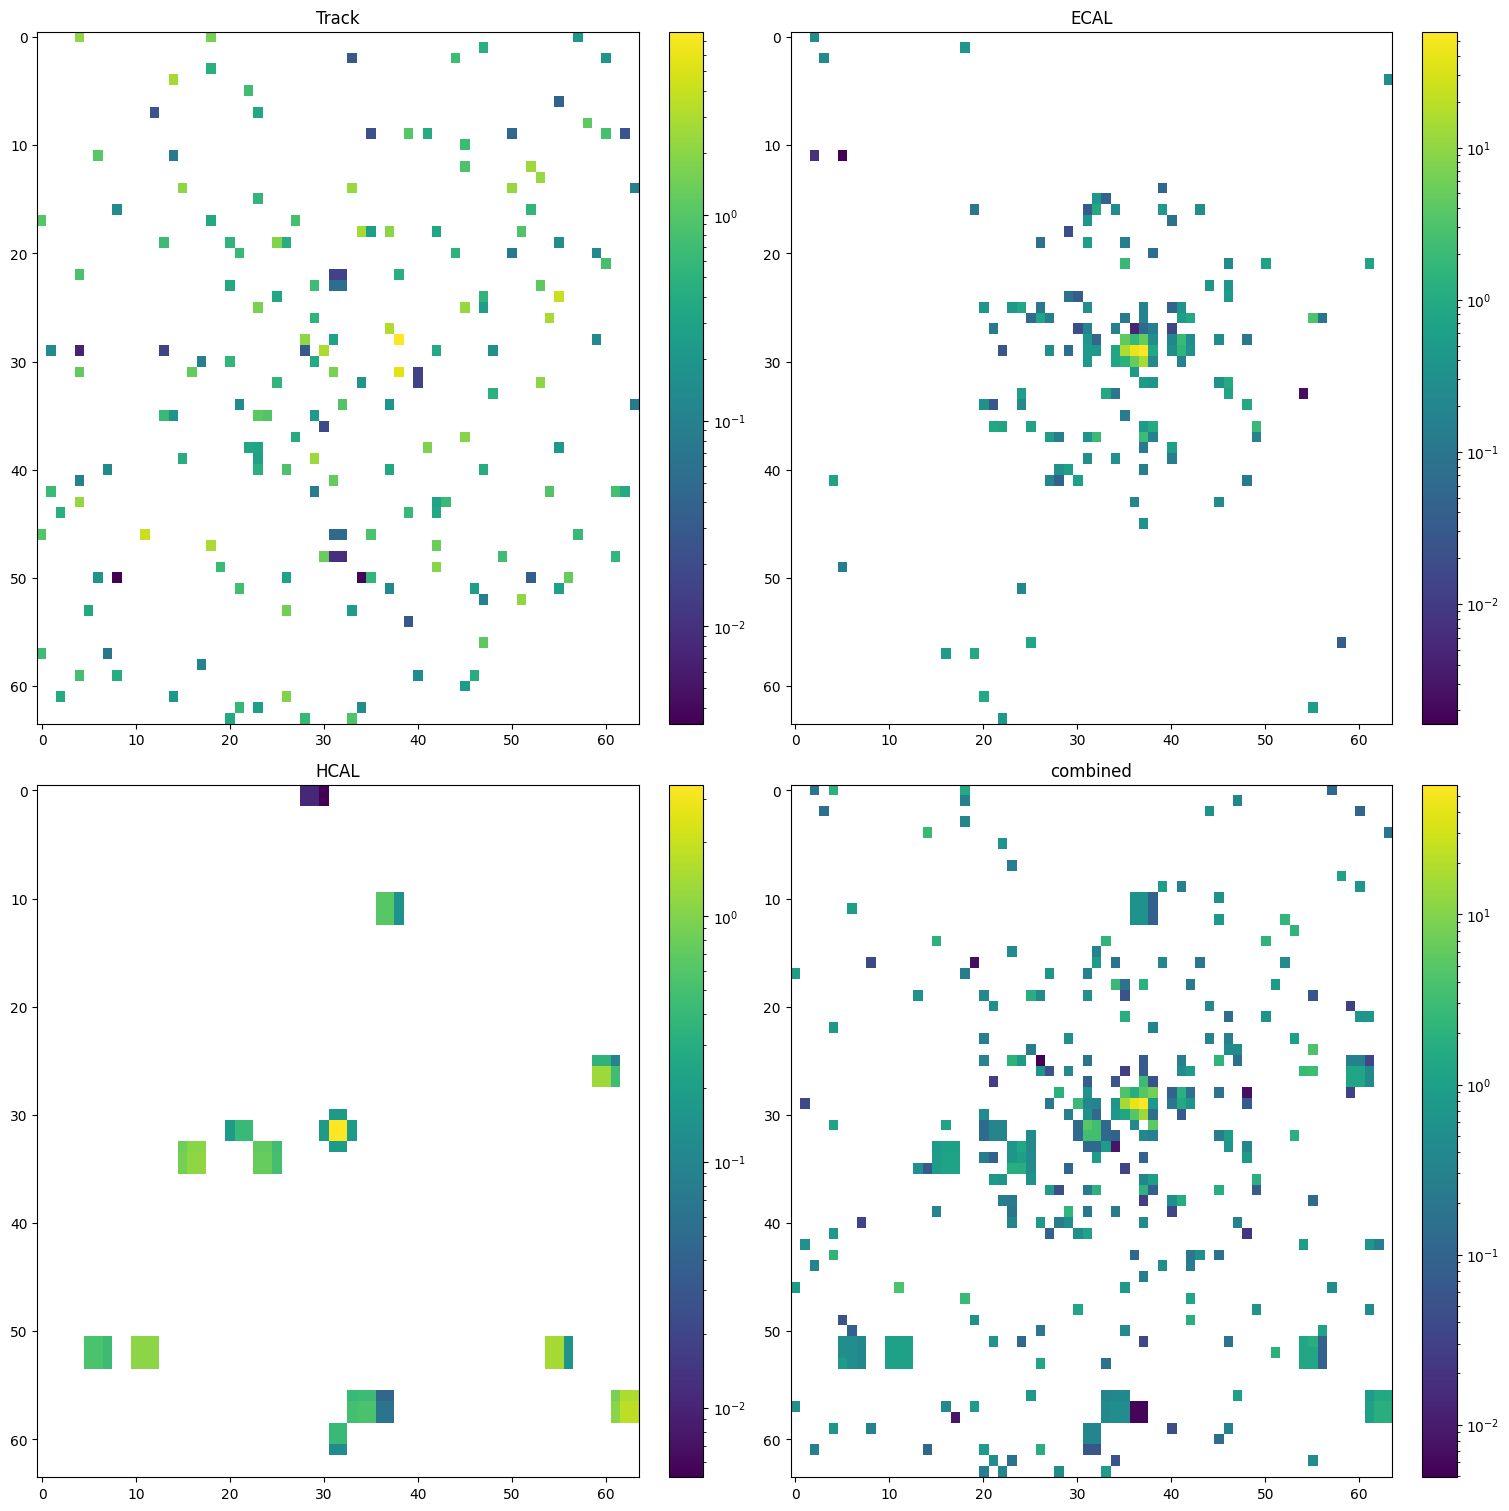

In [7]:

X_jets, label = next(iter(train_dataloader))
print(X_jets.shape)
i = 10

tracks = X_jets[i][0,:,:] 
ecal = X_jets[i][1,:,:] 
hcal = X_jets[i][2,:,:] 
combined = tracks + ecal + hcal

fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)

im_tracks = axs[0,0].imshow(tracks,  aspect='auto', norm=colors.LogNorm())
axs[0,0].set_title('Track')
fig.colorbar(im_tracks, ax=axs[0,0])

im_ecal = axs[0,1].imshow(ecal,aspect='auto', norm=colors.LogNorm())
axs[0,1].set_title('ECAL')
fig.colorbar(im_ecal, ax=axs[0,1])

im_hcal = axs[1,0].imshow(hcal,  aspect='auto', norm=colors.LogNorm())
axs[1,0].set_title('HCAL')
fig.colorbar(im_hcal, ax=axs[1,0])

im_combined = axs[1,1].imshow(combined,aspect='auto', norm=colors.LogNorm())
axs[1,1].set_title('combined')
fig.colorbar(im_combined, ax=axs[1,1])

plt.show()


## MODEL

In [8]:
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, output_channels)
        if up:
            self.conv1 = nn.Conv2d(2*input_channels, output_channels, 3, padding=1)
            self.transform = nn.ConvTranspose2d(output_channels, output_channels, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(input_channels, output_channels, 3, padding=1)
            self.transform = nn.Conv2d(output_channels, output_channels, 4, 2, 1)
        self.conv2 = nn.Conv2d(output_channels, output_channels, 3, padding=1)
        # self.bnorm1 = nn.BatchNorm2d(out_ch)
        # self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.relu(self.conv1(x))   
        time_emb = self.relu(self.time_mlp(t))      
        time_emb = time_emb[(..., ) + (None, ) * 2]  

        h = h + time_emb       

        h = self.relu(self.conv2(h))   
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3

        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)


        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(                              
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)      


        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        
        t = self.time_mlp(timestep)

        x = x.float()    
        x = self.conv0(x)          

        residual_inputs = []            
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()

    
            x = torch.cat((x, residual_x), dim=1)       

            x = up(x, t)
        return self.output(x)

## 1) DDPM

In [12]:


def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

class DenoiseDiffusion_DDPM:
  def __init__(self,eps_model:nn.Module,n_steps:int,device:torch.device):
    super().__init__()
    self.eps_model=eps_model
    self.beta=torch.linspace(0.0001,0.02,n_steps).to(device) #linear beta scheduling
    self.alpha=1-self.beta
    self.alpha_bar=torch.cumprod(self.alpha,dim=0)
    self.n_steps=n_steps
    self.sigma2=self.beta
  
  def q_xt_x0(self,x_0:torch.Tensor,t:torch.Tensor):
    mean=gather(self.alpha_bar,t)**0.5*x_0
    var=1-gather(self.alpha_bar,t)
    return mean,var

  def q_sample(self,x0:torch.Tensor,t:torch.Tensor,eps:Optional[torch.Tensor]=None):
    if eps is None:
      eps=torch.rand_like(x0)
    mean,var=self.q_xt_x0(x0,t)
    #eps.view(*eps.shape,1,params['image_size'],params['image_size'])
    return mean+(var**0.5)*eps
  
  def p_sample(self,xt:torch.Tensor,t:torch.Tensor):
    eps_theta=self.eps_model(xt,t)
    alpha_bar=gather(self.alpha_bar,t)
    alpha=gather(self.alpha,t)
    eps_coef=(1-alpha)/(1-alpha_bar)**0.5
    mean=(1/(alpha**0.5))*(xt-eps_coef*eps_theta)
    var=gather(self.sigma2,t)
    eps=torch.randn(xt.shape,device=xt.device)
    return mean+(var**0.5)*eps
  
  def loss(self,x0:torch.Tensor):
    batch_size=x0.shape[0]
    t=torch.randint(0,self.n_steps,(batch_size,),device=x0.device,dtype=torch.long)
    
    noise=torch.randn_like(x0)
    xt=self.q_sample(x0,t,eps=noise)
    eps_theta=self.eps_model(xt,t)
    return F.mse_loss(noise,eps_theta),eps_theta

  @torch.no_grad()
  def sample_plot_image(self,epoch):
      # Sample noise
      img_size = 64
      img = torch.randn((1, 3, img_size, img_size), device=self.beta.device)
      plt.figure(figsize=(15,5))
      plt.axis('off')
      num_images = 5
      stepsize = int(self.n_steps/num_images)

      for i in range(0,self.n_steps)[::-1]:
          temp = torch.full((1,), i, device=img.device, dtype=torch.long)
          img = self.p_sample(img, temp)
          if i % stepsize == 0:
              plt.subplot(1, num_images, math.ceil(i/stepsize)+1)
              self.show_tensor_image(img.detach().cpu())
              plt.title(f'timestep: {i}')  #backward diffusion start from noise at t=T and reconstruct image at t=0
      plt.savefig(f"{epoch} epochs")
      plt.show()   

  def show_tensor_image(self,image):
      reverse_transforms = torchvision.transforms.Compose([
          torchvision.transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
          torchvision.transforms.Lambda(lambda t: t.numpy()),

      ]) 
      # Take first image of batch
      if len(image.shape) == 4:
          image = image[0, :, :, :] 
      image = reverse_transforms(image)
      combined = torch.sum(torch.tensor(image),dim=-1)

      plt.imshow(combined,aspect='auto',norm=colors.LogNorm())
      

In [13]:
x_jets,_ = next(iter(train_dataloader))
x_jets[0].shape

torch.Size([3, 64, 64])

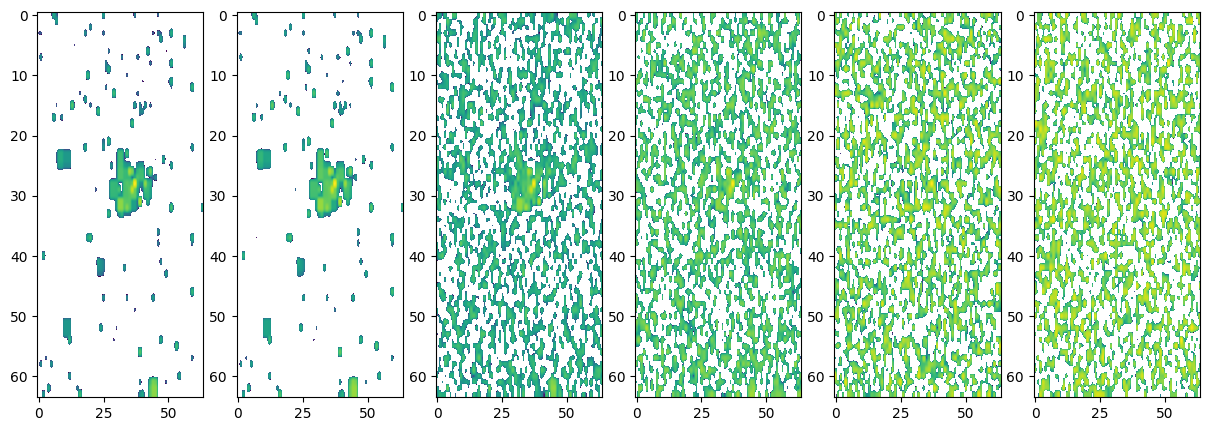

In [14]:
T = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
ddpm= DenoiseDiffusion_DDPM(model,T,device)
image = x_jets[0].to(device)
# print(image.shape)

num_images = 5
stepsize = int(T/num_images)

plt.figure(figsize=(15, 5))
plt.axis('off')
plt.subplot(1, num_images + 1, 1)

ddpm.show_tensor_image(image.detach().cpu())

for t in range(0,T,stepsize):
    noise  = torch.randn_like(image)
    noisy_image = ddpm.q_sample(image, torch.tensor([t],device=image.device),noise)
    # print(noisy_image.shape)
    plt.subplot(1,num_images+1,math.ceil((t/stepsize))+2)
    ddpm.show_tensor_image(noisy_image.detach().cpu())
plt.show()


50it [00:18,  2.68it/s]00:00<?, ?it/s]
50it [00:18,  2.72it/s]00:18<09:02, 18.71s/it]
50it [00:18,  2.71it/s]00:37<08:39, 18.55s/it]
50it [00:18,  2.69it/s]00:55<08:20, 18.54s/it]
 13%|█▎        | 4/30 [01:14<08:02, 18.57s/it]

Epoch 4 | step 000 Loss: 0.12160205841064453 


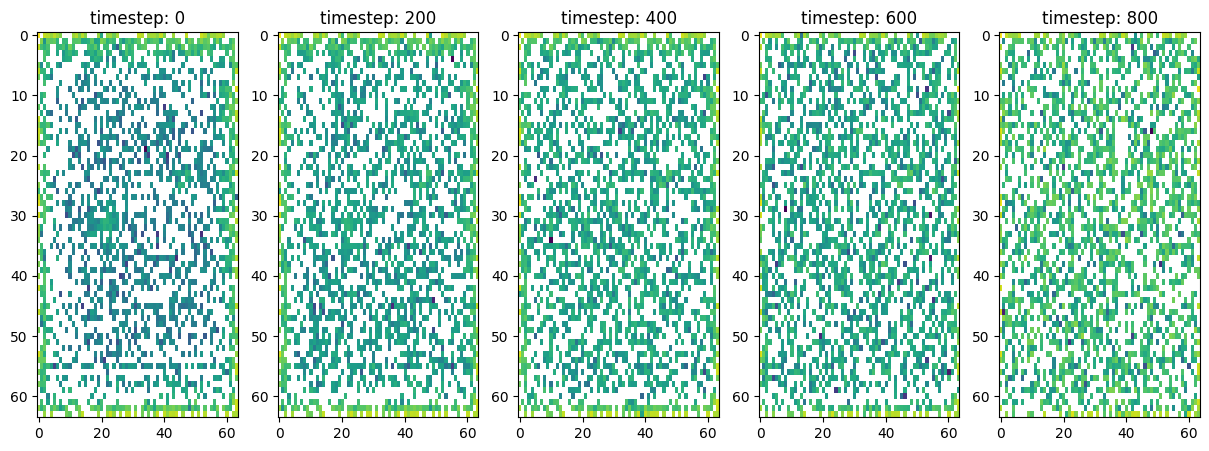

50it [00:22,  2.18it/s]
50it [00:19,  2.59it/s]01:37<08:23, 20.16s/it]
50it [00:19,  2.55it/s]01:56<07:57, 19.88s/it]
50it [00:19,  2.53it/s]02:16<07:35, 19.80s/it]
50it [00:19,  2.51it/s]02:36<07:15, 19.81s/it]
 30%|███       | 9/30 [02:56<06:57, 19.86s/it]

Epoch 9 | step 000 Loss: 0.07384615391492844 


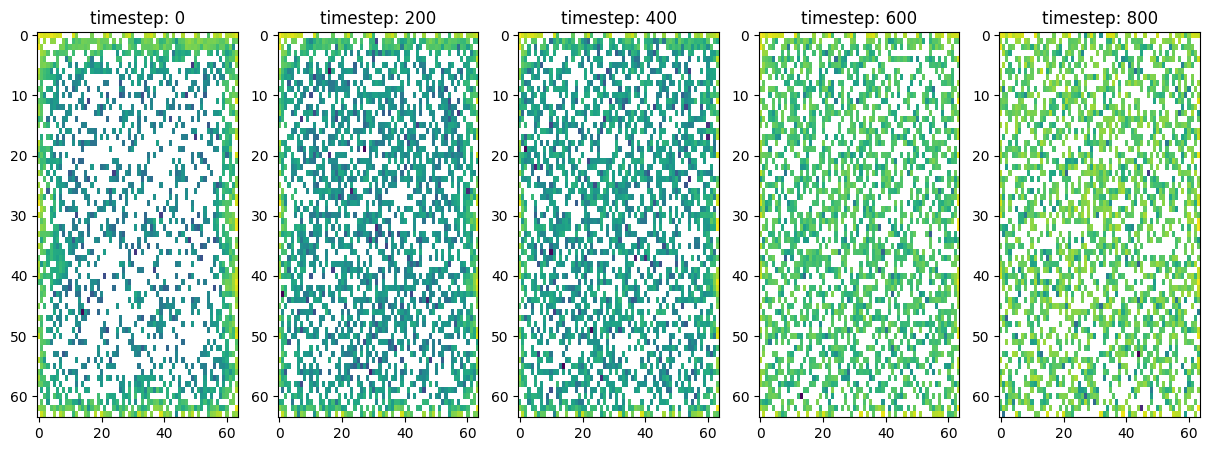

50it [00:24,  2.06it/s]
50it [00:20,  2.48it/s][03:20<07:04, 21.23s/it]
50it [00:20,  2.48it/s][03:40<06:37, 20.92s/it]
50it [00:20,  2.48it/s][04:00<06:12, 20.69s/it]
50it [00:20,  2.48it/s][04:20<05:49, 20.55s/it]
 47%|████▋     | 14/30 [04:41<05:27, 20.46s/it]

Epoch 14 | step 000 Loss: 0.06818811595439911 


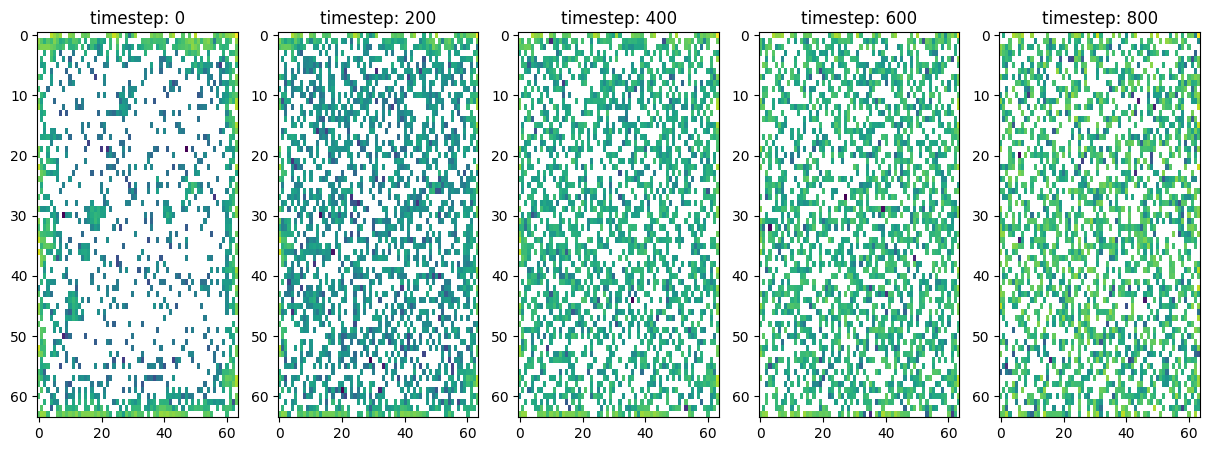

50it [00:24,  2.02it/s]
50it [00:20,  2.45it/s][05:05<05:26, 21.76s/it]
50it [00:20,  2.45it/s][05:26<04:59, 21.37s/it]
50it [00:20,  2.45it/s][05:46<04:34, 21.10s/it]
50it [00:20,  2.45it/s][06:07<04:10, 20.91s/it]
 63%|██████▎   | 19/30 [06:27<03:48, 20.78s/it]

Epoch 19 | step 000 Loss: 0.0440397709608078 


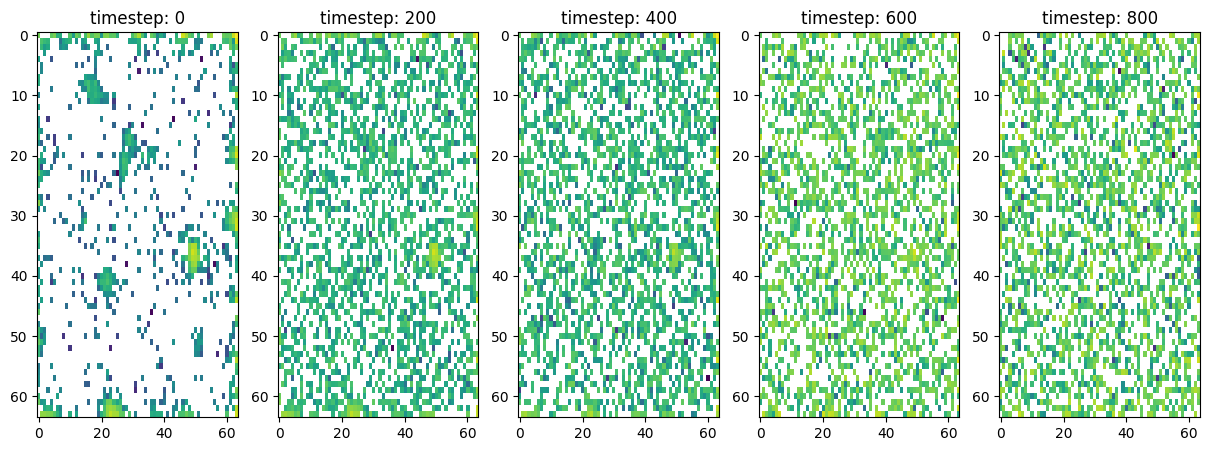

50it [00:24,  2.02it/s]
50it [00:20,  2.44it/s][06:52<03:39, 21.99s/it]
50it [00:20,  2.45it/s][07:13<03:13, 21.55s/it]
50it [00:20,  2.45it/s][07:33<02:49, 21.23s/it]
50it [00:20,  2.44it/s][07:54<02:27, 21.01s/it]
 80%|████████  | 24/30 [08:14<02:05, 20.86s/it]

Epoch 24 | step 000 Loss: 0.038515474647283554 


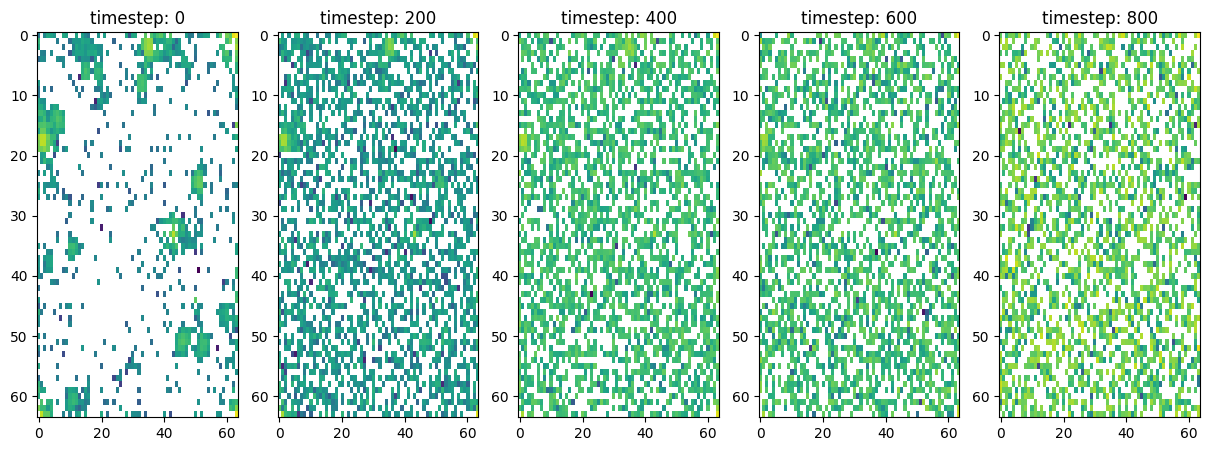

50it [00:25,  2.00it/s]
50it [00:20,  2.44it/s][08:39<01:50, 22.12s/it]
50it [00:20,  2.44it/s][09:00<01:26, 21.64s/it]
50it [00:20,  2.44it/s][09:20<01:03, 21.32s/it]
50it [00:20,  2.44it/s][09:41<00:42, 21.09s/it]
 97%|█████████▋| 29/30 [10:01<00:20, 20.93s/it]

Epoch 29 | step 000 Loss: 0.029653385281562805 


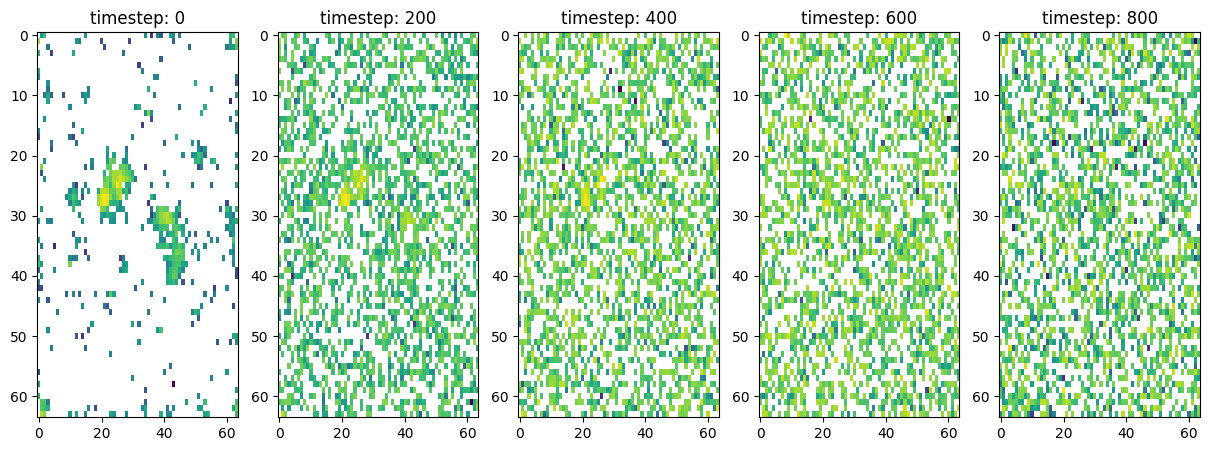

50it [00:24,  2.01it/s]
100%|██████████| 30/30 [10:26<00:00, 20.90s/it]


In [15]:
for epoch in tqdm(range(30)):
    for step, (jets,labels) in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()
        loss,reconstructed = ddpm.loss(jets.to(device))
        loss.backward()
        optimizer.step()

        if (epoch+1)%5==0 and step==0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            ddpm.sample_plot_image(epoch)

Text(0.5, 1.0, 'Combined Reconstructed')

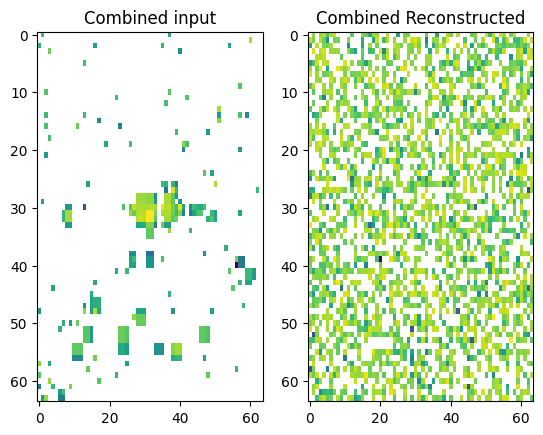

In [16]:
test_X_jets, test_label = next(iter(test_dataloader))
i = 100
_,test_reconstruction = ddpm.loss(test_X_jets.to(device))
plt.subplot(1,2,1)
ddpm.show_tensor_image(test_X_jets[i])
plt.title('Combined input')
plt.subplot(1,2,2)
ddpm.show_tensor_image(test_reconstruction[i].detach().cpu())
plt.title('Combined Reconstructed')


In [17]:

  @torch.no_grad()
  def sample_plot_image():
      # Sample noise
      img_size = 64
      img = test_X_jets[0].to(device)
      plt.figure(figsize=(15,5))
      plt.axis('off')
      num_images = 5
      stepsize = int(ddpm.n_steps/num_images)

      for i in range(0,ddpm.n_steps):
          noise  = torch.randn_like(image)
          noisy_image = ddpm.q_sample(img, torch.tensor([t],device=image.device),noise)

      for i in range(0,ddpm.n_steps)[::-1]:
          temp = torch.full((1,), i, device=img.device, dtype=torch.long)
          img = ddpm.p_sample(noisy_image, temp)
          if i % stepsize == 0:
              plt.subplot(1, num_images, math.ceil(i/stepsize)+1)
              ddpm.show_tensor_image(img.detach().cpu())
              plt.title(f'timestep: {i}')  #backward diffusion start from noise at t=T and reconstruct image at t=0
    #   plt.savefig(f"{epoch} epochs")
      plt.show()   

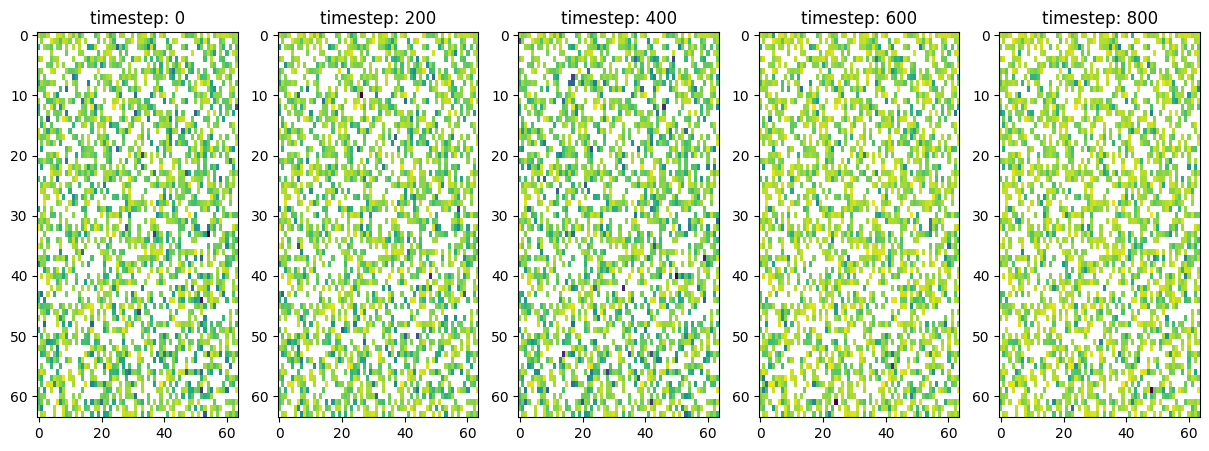

In [18]:
sample_plot_image()

## 2) DDIM

In [9]:
from torch import nn
from torchvision import transforms 
from typing import Optional
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

class DenoiseDiffusion_DDIM:
  def __init__(self,eps_model:nn.Module,n_steps:int,device:torch.device):
    super().__init__()
    self.eps_model=eps_model
    self.beta=torch.linspace(0.0001,0.02,n_steps).to(device)
    self.time_steps=np.asarray(list(range(0,n_steps,1))) 
    self.alpha=1-self.beta
    self.alpha_bar=torch.cumprod(self.alpha,dim=0)

    self.ddim_alpha=self.alpha_bar[self.time_steps].clone().to(torch.float32)
    self.ddim_alpha_sqrt=torch.sqrt(self.ddim_alpha)
    
    self.alpha_prev=torch.cat([self.alpha_bar[0:1], self.alpha_bar[self.time_steps[:-1]]])
    self.n_steps=n_steps
  
  def q_xt_x0(self,x_0:torch.Tensor,t:torch.Tensor):
    mean=gather(self.alpha_bar,t)**0.5*x_0
    var=1-gather(self.alpha_bar,t)
    return mean,var

  def q_sample(self,x0:torch.Tensor,t:torch.Tensor,eps:Optional[torch.Tensor]=None):
    if eps is None:
      eps=torch.rand_like(x0)
    mean,var=self.q_xt_x0(x0,t)
    return mean+(var**0.5)*eps
  
  def p_sample(self,xt:torch.Tensor,t:torch.Tensor):
    eps_theta=self.eps_model(xt,t)
    alpha=gather(self.ddim_alpha,t)
    alpha_prev=gather(self.alpha_prev,t)
    sqrt_one_minus_alpha=(1-alpha).sqrt()
    pred_x0=(xt-sqrt_one_minus_alpha*eps_theta)/(alpha**0.5)
    dir_xt=(1.-alpha_prev).sqrt()*eps_theta
    prev=(alpha_prev**0.5)*pred_x0+dir_xt    
    return prev
  
  
  def loss(self,x0:torch.Tensor):
    batch_size=x0.shape[0]
    t=torch.randint(0,self.n_steps,(batch_size,),device=x0.device,dtype=torch.long)
    
    noise=torch.randn_like(x0)
    xt=self.q_sample(x0,t,eps=noise)
    eps_theta=self.eps_model(xt,t)
    return F.mse_loss(noise,eps_theta),eps_theta
    
  @torch.no_grad()
  def sample_plot_image(self,epoch):
      # Sample noise
      img_size = 64
      img = torch.randn((1, 3, img_size, img_size), device=self.beta.device)
      plt.figure(figsize=(15,5))
      plt.axis('off')
      num_images = 5
      stepsize = int(self.n_steps/num_images)

      for i in range(0,self.n_steps)[::-1]:
          temp = torch.full((1,), i, device=img.device, dtype=torch.long)
          img = self.p_sample(img, temp)
          if i % stepsize == 0:
              plt.subplot(1, num_images, math.ceil(i/stepsize)+1)
              self.show_tensor_image(img.detach().cpu())
              plt.title(f'timestep: {i}')  #backward diffusion start from noise at t=T and reconstruct image at t=0
      plt.savefig(f"{epoch} epochs")
      plt.show()   

  def show_tensor_image(self,image):
      reverse_transforms = torchvision.transforms.Compose([
          torchvision.transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
          torchvision.transforms.Lambda(lambda t: t.numpy()),

      ]) 
      # Take first image of batch
      if len(image.shape) == 4:
          image = image[0, :, :, :] 
      image = reverse_transforms(image)
      combined = torch.sum(torch.tensor(image),dim=-1)

      plt.imshow(combined,aspect='auto',norm=colors.LogNorm())

In [10]:
x_jets,_ = next(iter(train_dataloader))
x_jets[0].shape

torch.Size([3, 64, 64])

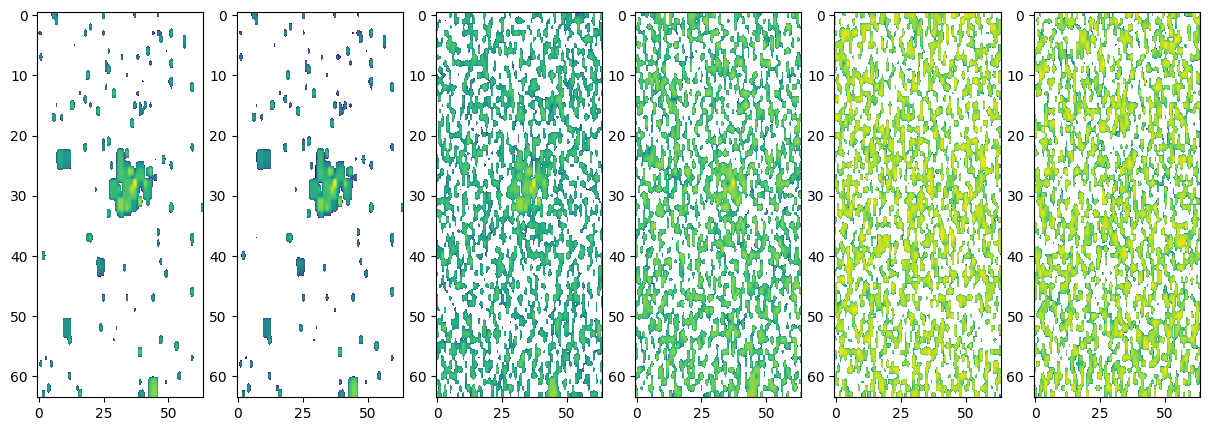

In [11]:
T = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
ddim= DenoiseDiffusion_DDIM(model,T,device)
image = x_jets[0].to(device)

num_images = 5
stepsize = int(T/num_images)

plt.figure(figsize=(15, 5))
plt.axis('off')
plt.subplot(1, num_images + 1, 1)

ddim.show_tensor_image(image.detach().cpu())

for t in range(0,T,stepsize):
    noise  = torch.randn_like(image)
    noisy_image = ddim.q_sample(image, torch.tensor([t],device=image.device),noise)
    # print(noisy_image.shape)
    plt.subplot(1,num_images+1,math.ceil((t/stepsize))+2)
    ddim.show_tensor_image(noisy_image.detach().cpu())
plt.show()


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 | step 000 Loss: 1.0047314167022705 


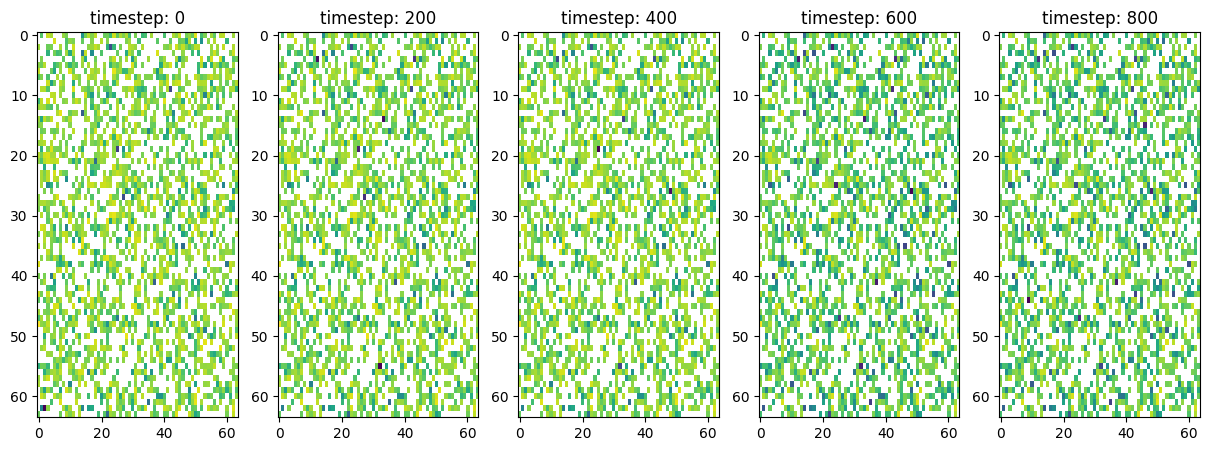

50it [00:23,  2.14it/s]
50it [00:18,  2.69it/s]00:23<11:19, 23.42s/it]
50it [00:18,  2.69it/s]00:42<09:36, 20.60s/it]
50it [00:18,  2.66it/s]01:00<08:52, 19.71s/it]
50it [00:19,  2.59it/s]01:19<08:23, 19.37s/it]
 17%|█▋        | 5/30 [01:38<08:03, 19.36s/it]

Epoch 5 | step 000 Loss: 0.10667391121387482 


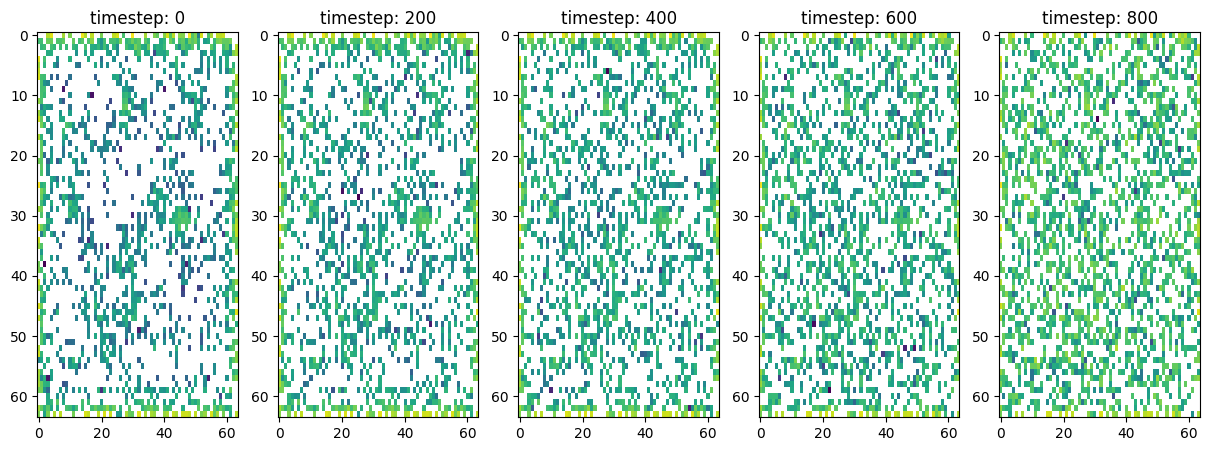

50it [00:23,  2.09it/s]
50it [00:20,  2.50it/s]02:02<08:22, 20.94s/it]
50it [00:20,  2.48it/s]02:22<07:55, 20.66s/it]
50it [00:20,  2.47it/s]02:43<07:31, 20.54s/it]
50it [00:20,  2.47it/s]03:03<07:09, 20.47s/it]
 33%|███▎      | 10/30 [03:23<06:48, 20.43s/it]

Epoch 10 | step 000 Loss: 0.08076365292072296 


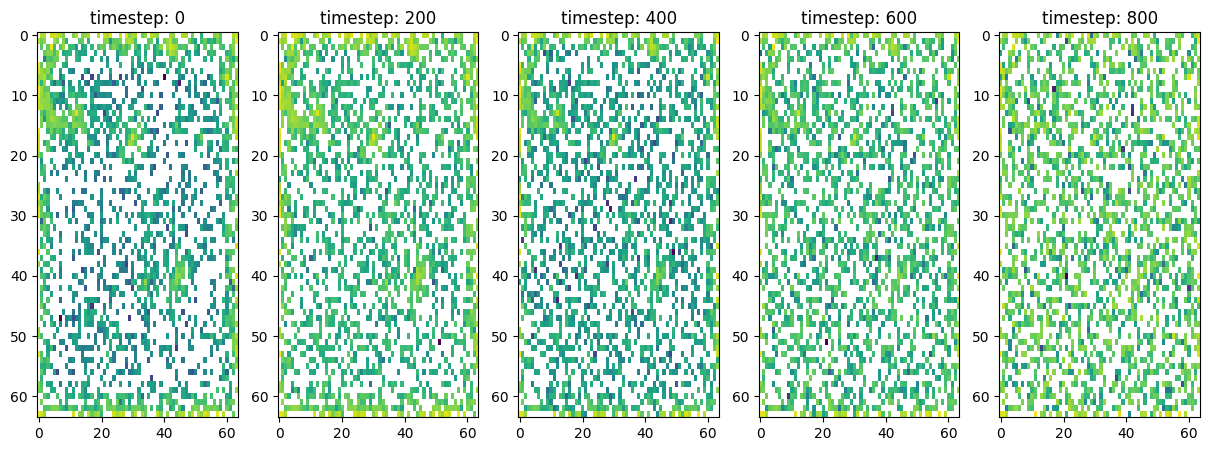

50it [00:24,  2.02it/s]
50it [00:20,  2.45it/s][03:48<06:53, 21.76s/it]
50it [00:20,  2.45it/s][04:09<06:24, 21.37s/it]
50it [00:20,  2.45it/s][04:29<05:58, 21.11s/it]
50it [00:20,  2.43it/s][04:50<05:34, 20.92s/it]
 50%|█████     | 15/30 [05:10<05:12, 20.83s/it]

Epoch 15 | step 000 Loss: 0.05477984994649887 


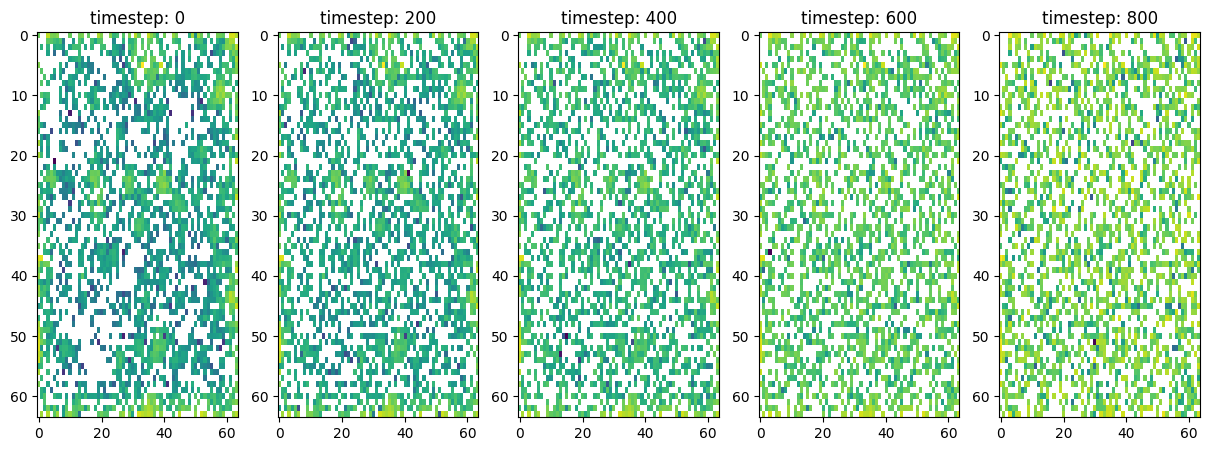

50it [00:25,  1.99it/s]
50it [00:20,  2.42it/s][05:35<05:09, 22.13s/it]
50it [00:20,  2.42it/s][05:56<04:42, 21.71s/it]
50it [00:20,  2.42it/s][06:17<04:16, 21.41s/it]
50it [00:20,  2.42it/s][06:38<03:53, 21.21s/it]
 67%|██████▋   | 20/30 [06:58<03:30, 21.06s/it]

Epoch 20 | step 000 Loss: 0.04876440018415451 


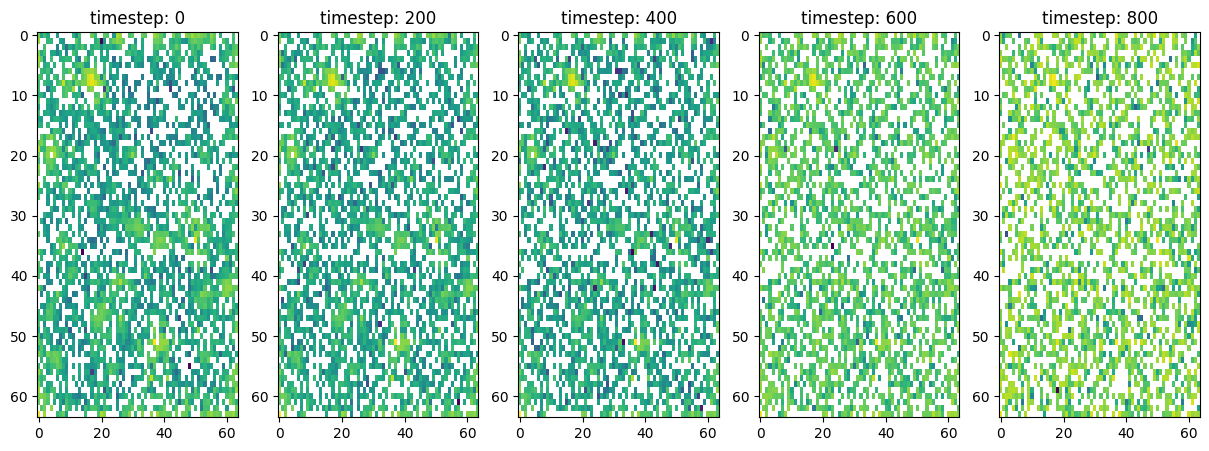

50it [00:25,  2.00it/s]
50it [00:20,  2.42it/s][07:23<03:20, 22.26s/it]
50it [00:20,  2.43it/s][07:44<02:54, 21.81s/it]
50it [00:20,  2.41it/s][08:05<02:30, 21.47s/it]
50it [00:20,  2.41it/s][08:26<02:07, 21.29s/it]
 83%|████████▎ | 25/30 [08:46<01:45, 21.14s/it]

Epoch 25 | step 000 Loss: 0.0341680608689785 


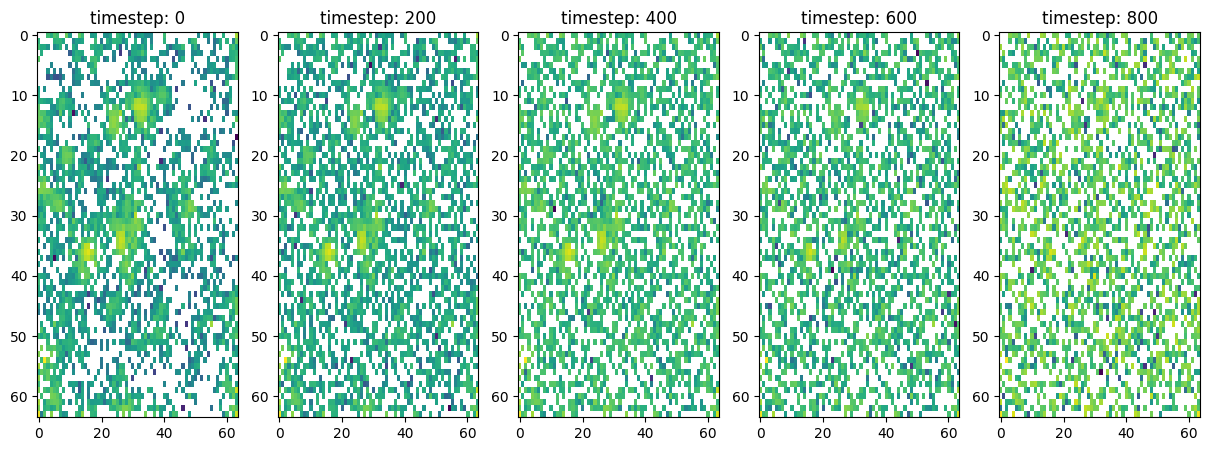

50it [00:25,  1.99it/s]
50it [00:20,  2.42it/s][09:12<01:29, 22.36s/it]
50it [00:20,  2.41it/s][09:32<01:05, 21.88s/it]
50it [00:20,  2.41it/s][09:53<00:43, 21.56s/it]
50it [00:20,  2.41it/s][10:14<00:21, 21.33s/it]
100%|██████████| 30/30 [10:35<00:00, 21.18s/it]


In [12]:
for epoch in tqdm(range(30)):
    for step, (jets,labels) in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()

        loss,reconstructed = ddim.loss(jets.to(device))
        loss.backward()
        optimizer.step()

        if epoch%5==0 and step==0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            ddim.sample_plot_image(epoch)

Text(0.5, 1.0, 'Combined Reconstructed')

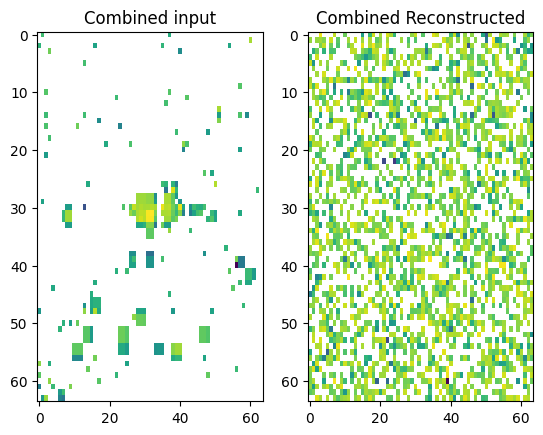

In [13]:
test_X_jets, test_label = next(iter(test_dataloader))
i = 100
_,test_reconstruction = ddim.loss(test_X_jets.to(device))
plt.subplot(1,2,1)
ddim.show_tensor_image(test_X_jets[i])
plt.title('Combined input')
plt.subplot(1,2,2)
ddim.show_tensor_image(test_reconstruction[i].detach().cpu())
plt.title('Combined Reconstructed')


## DISCUSSION
* Implemented both DDPM(Denoising Diffusion Probabilistic Model) and DDIM (Denoising Diffusion Implict Models), the reconstruction seemed to be bad when tried on test image, but on training data reconstruction from a random noise seemed to improve over period of time. Potential reason could be the number of samples taken are less.

* The choice of scheduler is very important, here I have used linear scheduler

* As the data doesn't contain normal RGB channels and instead has different channels like ECAL,HCAL,Tracks normal convolutions might not be a good choice as they are good in extracting features from normal structured images. If the pixels change then the image loses its meaning.

* A choice could be to implement diffusion in the graphs  https://arxiv.org/abs/1911.05485, after converting the data into a graphical representation.

## REFERENCES - 

1) https://arxiv.org/abs/2006.11239 DDPM
2) https://arxiv.org/abs/2010.02502 DDIM
3) https://github.com/cjfghk5697/Pytorch-Research-Paper-Implementations/tree/main/Diffusion
4) https://medium.com/@akshit.chodhary/wrap-up-gsoc-2023-ml4sci-2f98adaa21ae
5) https://www.tonyduan.com/diffusion/index.html